In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from scipy.io import loadmat
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedGroupKFold, GroupShuffleSplit, cross_val_score

In [2]:
data = loadmat('./data/landsat_data.mat')
im = np.array(data['landsat_data'])

print(f'Data type: {im.dtype}')
print(f'Data shape: {im.shape}')

Data type: uint8
Data shape: (512, 512, 7)


In [3]:
# Computation of NDVI:
numerator = im[:,:,3].astype(float) - im[:,:,2].astype(float)
denominator = im[:,:,3].astype(float) + im[:,:,2].astype(float) + 0.001
ndvi = numerator / denominator
ndvi = np.clip(a=np.floor((ndvi + 1) * 128), a_min=0, a_max=255).astype(np.uint8)

im = np.dstack([im, ndvi])

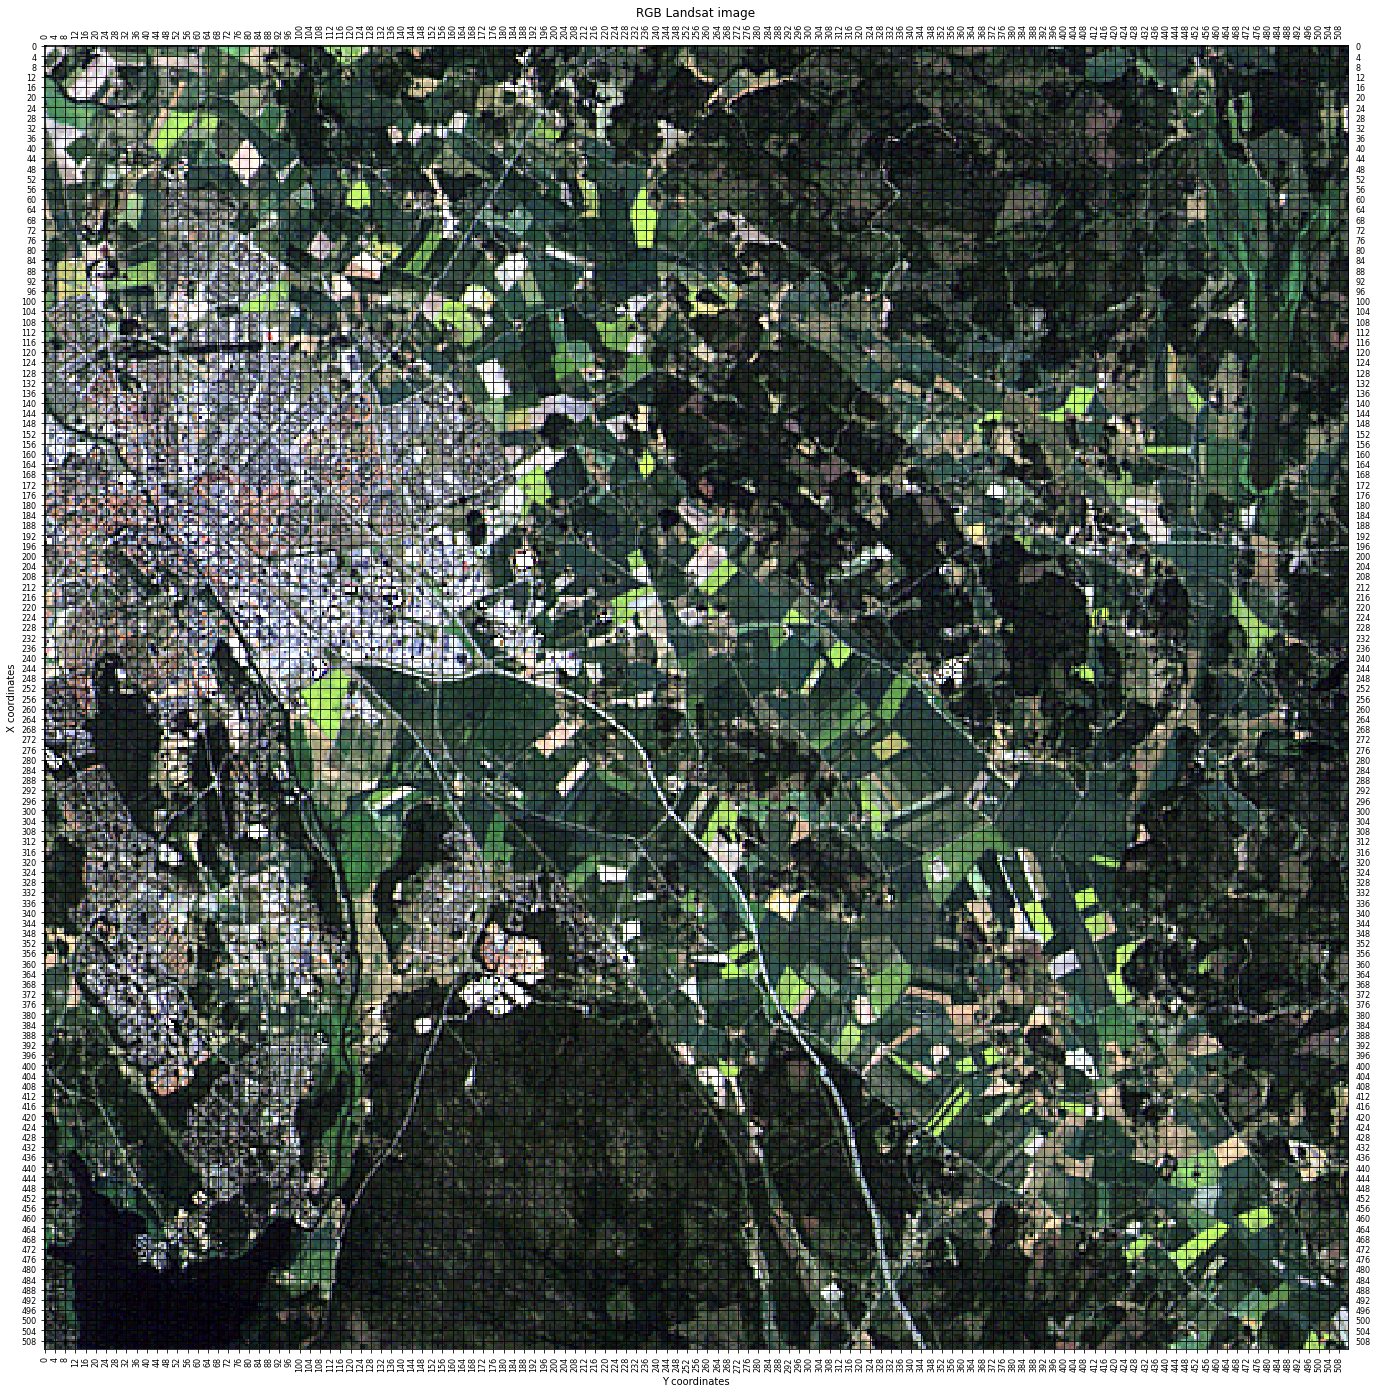

In [4]:
fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(24, 24))

implot = ax0.imshow(im[:,:, (2,1,0)], interpolation='none')
ax0.set_title('RGB Landsat image')
ax0.set_xticks(np.linspace(start=0, stop=im.shape[0], num=128, endpoint=False).astype(int))
ax0.set_yticks(np.linspace(start=0, stop=im.shape[1], num=128, endpoint=False).astype(int))
ax0.tick_params(axis="x", labelsize=8, rotation=90, labeltop=True)
ax0.tick_params(axis="y", labelsize=8, rotation=0, labelright=True)
ax0.set_xlabel('Y coordinates')
ax0.set_ylabel('X coordinates')
ax0.grid(color='black', linestyle='-', linewidth=0.8)

In [5]:
labels = {1:'Water', 2:'Urban area', 3:'Agricultural area', 4:'Forest'}

data = np.zeros(shape=(im.shape[0], im.shape[1], 2), dtype=np.uint8)

data[491:501, 30:40] = [1,1]
data[112:128, 481:486] = [1,2]
data[143:158, 476:481] = [1,3]

data[153:168, 76:87] = [2,4]
data[230:240, 128:138] = [2,5]
data[184:189, 10:25] = [2,6]
data[158:173, 158:173] = [2,7]

data[353:368, 291:307] = [3,8]
data[261:266, 322:337] = [3,9]
data[122:126, 325:345] = [3,10]
data[58:65, 380:391] = [3,11]

data[460:470, 150:180] = [4,12]
data[163:173, 276:286] = [4,13]
data[476:506, 373:378] = [4,14]
data[220:235, 384:400] = [4,15]

x_coord, y_coord = data[:,:,0].nonzero()
dict_data = {'PolygonID': data[x_coord, y_coord, 1],
     'B1': im[x_coord, y_coord, 0],
     'B2': im[x_coord, y_coord, 1],
     'B3': im[x_coord, y_coord, 2],
     'B4': im[x_coord, y_coord, 3],
     'B5': im[x_coord, y_coord, 4],
     'B6': im[x_coord, y_coord, 5],
     'B7': im[x_coord, y_coord, 6],
     'NDVI': im[x_coord, y_coord, 7],
     'Class': data[x_coord, y_coord, 0],
     'coord': zip(x_coord, y_coord)
     }

df_data = pd.DataFrame(data=dict_data, dtype=np.uint8)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2082 entries, 0 to 2081
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PolygonID  2082 non-null   uint8 
 1   B1         2082 non-null   uint8 
 2   B2         2082 non-null   uint8 
 3   B3         2082 non-null   uint8 
 4   B4         2082 non-null   uint8 
 5   B5         2082 non-null   uint8 
 6   B6         2082 non-null   uint8 
 7   B7         2082 non-null   uint8 
 8   NDVI       2082 non-null   uint8 
 9   Class      2082 non-null   uint8 
 10  coord      2082 non-null   object
dtypes: object(1), uint8(10)
memory usage: 36.7+ KB


In [6]:
x = df_data.drop(columns=['Class'], inplace=False)
y = df_data['Class']

gss = GroupShuffleSplit(n_splits=1, train_size=.6, random_state=100)
for idx_train, idx_test in gss.split(x, y, groups=df_data['PolygonID']):
    x_train, y_train = x.iloc[idx_train], y.iloc[idx_train]
    x_test, y_test = x.iloc[idx_test], y.iloc[idx_test]

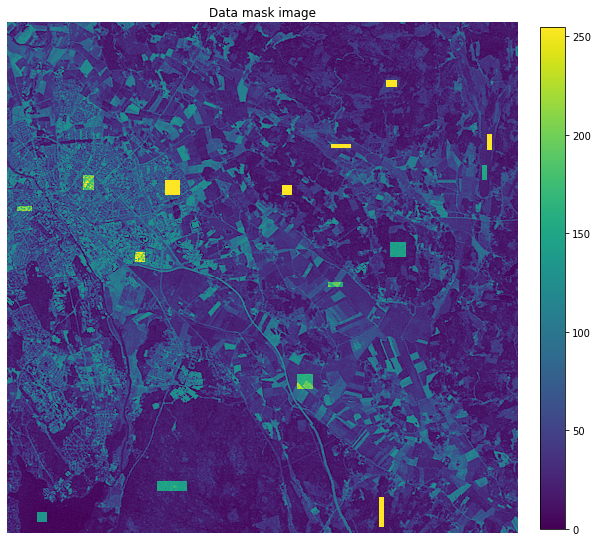

In [7]:
data_mask = np.zeros(shape=data.shape[:-1], dtype=np.uint8)
for x,y in x_train['coord']:
    data_mask[x,y] = 128
for x,y in x_test['coord']:
    data_mask[x,y] = 255
im_gray = cv.cvtColor(src=im[:,:,(2,1,0)], code=cv.COLOR_RGB2GRAY)
data_mask = cv.addWeighted(src1=im_gray, alpha=0.5, src2= data_mask, beta=1, gamma=0)

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

implot = ax0.imshow(data_mask, interpolation='none')
ax0.set_title('Data mask image')
ax0.axis('off')
cbar = fig.colorbar(implot, fraction=0.045, pad=0.04)

In [8]:
def box_plot(channel):
    if channel == 'NDVI' or channel == 'ndvi':
        feature = x_train['NDVI']
    else:
        feature = x_train[f'B{channel}']
    c1 = feature[y_train == 1]
    c2 = feature[y_train == 2]
    c3 = feature[y_train == 3]
    c4 = feature[y_train == 4]

    feature_dict = {'Water': c1, 'Urban': c2, 'Agriculture': c3, 'Forest': c4}

    fig, ax = plt.subplots()
    ax.set_title(f'Boxplot Channel = {channel}')
    ax.boxplot(feature_dict.values())
    ax.set_xticklabels(feature_dict.keys())

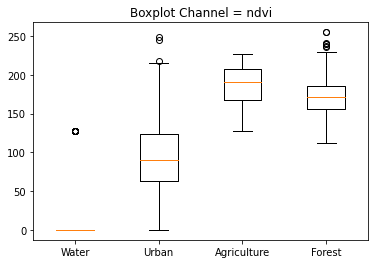

In [9]:
box_plot('ndvi')

In [10]:
polygonIds = x_train['PolygonID']
x_train.drop(columns=['PolygonID', 'coord'], inplace=True)

rf_classifier = RandomForestClassifier(n_estimators=20, max_features='auto', max_samples=0.75, max_depth=20, oob_score=False)

sgkf = StratifiedGroupKFold(n_splits=8, shuffle=False)
scores = cross_val_score(rf_classifier, x_train, y_train, cv=sgkf, groups=polygonIds)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

rf_classifier = rf_classifier.fit(X=x_train, y=y_train)

0.96 accuracy with a standard deviation of 0.06


In [11]:
dict_im = {'B1': im[:, :, 0].reshape(-1),
     'B2': im[:, :, 1].reshape(-1),
     'B3': im[:, :, 2].reshape(-1),
     'B4': im[:, :, 3].reshape(-1),
     'B5': im[:, :, 4].reshape(-1),
     'B6': im[:, :, 5].reshape(-1),
     'B7': im[:, :, 6].reshape(-1),
     'NDVI': im[:, :, 7].reshape(-1)
     }
df_im = pd.DataFrame(data=dict_im, dtype=np.uint8)
df_im.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262144 entries, 0 to 262143
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   B1      262144 non-null  uint8
 1   B2      262144 non-null  uint8
 2   B3      262144 non-null  uint8
 3   B4      262144 non-null  uint8
 4   B5      262144 non-null  uint8
 5   B6      262144 non-null  uint8
 6   B7      262144 non-null  uint8
 7   NDVI    262144 non-null  uint8
dtypes: uint8(8)
memory usage: 2.0 MB


(-0.5, 511.5, 511.5, -0.5)

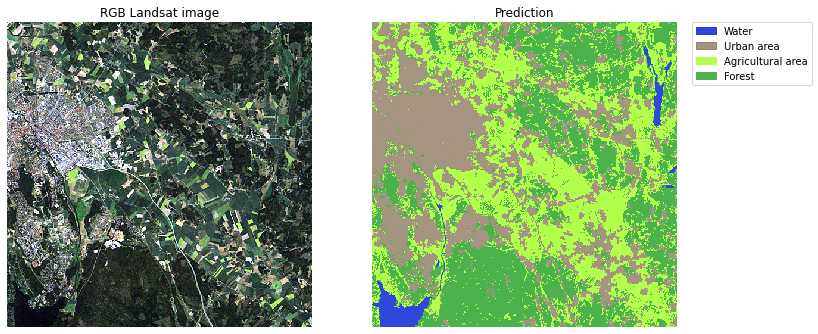

In [12]:
prediction_im = rf_classifier.predict(df_im).reshape(im.shape[:-1])

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

implot = ax0.imshow(im[:,:,(2,1,0)], interpolation='none')
ax0.set_title('RGB Landsat image')
ax0.axis('off')

cmap = {1:[0.1,0.2,0.85,0.9], 2:[0.5,0.4,0.3,0.7], 3:[0.7,1.0,0.3,1], 4:[0.3,0.7,0.3,1]}
prediction_plot = np.array([[cmap[col] for col in row] for row in prediction_im]) 
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

implot = ax1.imshow(prediction_plot, interpolation='none')
ax1.set_title('Prediction')
ax1.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax1.axis('off')

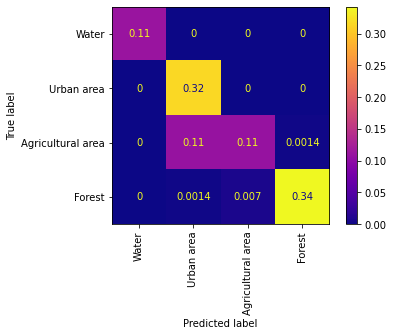

In [13]:
x_test.drop(columns=['PolygonID', 'coord'], inplace=True)

predictions = rf_classifier.predict(x_test)
cm = ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=predictions, normalize='all', display_labels=labels.values(), xticks_rotation='vertical', cmap=cm.plasma)